In [1]:
#Imports
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from datetime import datetime

In [2]:
# Enable GPU acceleration
def configure_gpu():
    try:
        # List physical devices
        physical_devices = tf.config.list_physical_devices('GPU')
        
        if physical_devices:
            # Print available GPUs
            print(f"Found {len(physical_devices)} GPU(s):")
            for device in physical_devices:
                print(f" - {device}")
                
            # Important: Set memory growth BEFORE setting any other GPU configurations
            try:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
                print("Memory growth enabled on all GPUs")
            except RuntimeError as e:
                print(f"Warning: {e}")
                
            # Enable mixed precision after memory growth configuration
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("Enabled mixed precision training")
        else:
            print("No GPU devices found")
            
    except Exception as e:
        print(f"Error configuring GPU: {e}")


configure_gpu()

No GPU devices found


In [3]:
# Paths for the dataset, anotations, working directory and images
TRAIN_PATH = 'D:/Download/JDownloader/MSCOCO/images/train2017'
VAL_PATH = 'D:/Download/JDownloader/MSCOCO/images/val2017'
ANNOTATIONS_PATH = 'D:/Download/JDownloader/MSCOCO/annotations'
WORKING_DIR = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working'
VAL_MODEL_IMG = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/val_model_img'
FILTERED_CATEGORIES = ['person', 'cat', 'dog']

In [4]:
# Load COCO annotations
annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_train2017.json')
coco = COCO(annotations_file)

# Get category IDs for the selected categories
category_ids = coco.getCatIds(catNms=FILTERED_CATEGORIES)

loading annotations into memory...
Done (t=8.19s)
creating index...
index created!


In [5]:
# Get total image count per category
category_image_counts = {}

for category_name, category_id in zip(FILTERED_CATEGORIES, category_ids):
    # Get all annotation IDs for the category
    ann_ids = coco.getAnnIds(catIds=[category_id])
    
    # Load annotations and extract unique image IDs
    anns = coco.loadAnns(ann_ids)
    image_ids = {ann['image_id'] for ann in anns}  # Use a set to ensure uniqueness
    
    # Count unique images
    category_image_counts[category_name] = len(image_ids)

# Print results
print("Total image count per category:")
for category, count in category_image_counts.items():
    print(f"{category}: {count}")

Total image count per category:
person: 64115
cat: 4114
dog: 4385


In [6]:
# Generate filtered dataset to train the model

# Collect up to 1000 annotations per category
filtered_data = []
for category_id in category_ids:
    ann_ids = coco.getAnnIds(catIds=[category_id])
    anns = coco.loadAnns(ann_ids)
    selected_anns = random.sample(anns, min(1000, len(anns)))
    for ann in selected_anns:
        image_info = coco.loadImgs(ann['image_id'])[0]
        filtered_data.append({
            "image_id": ann['image_id'],
            "image": image_info['file_name'],
            "category_id": ann['category_id']
        })

# Save filtered data to CSV
filtered_csv_path = os.path.join(WORKING_DIR, 'filtered_coco.csv')
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv(filtered_csv_path, index=False)

print(f"Filtered dataset saved to {os.path.abspath(filtered_csv_path)}")

Filtered dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\object_detection_model_compare\working\filtered_coco.csv


In [7]:
# Split the filtered dataset
# Load the filtered CSV
data = pd.read_csv(filtered_csv_path)

# Display record count per category_id
category_counts = data['category_id'].value_counts()
print("Record count per category_id:")
print(category_counts)
print("")

# Split into training and testing datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Display record count per category_id train and test
category_train_counts = train_data['category_id'].value_counts()
print("Train - Record count per category_id:")
print(category_train_counts)
print("")

category_test_counts = test_data['category_id'].value_counts()
print("Test - Record count per category_id:")
print(category_test_counts)
print("")

# Save the split datasets
train_csv_path = os.path.join(WORKING_DIR, 'train_data.csv')
test_csv_path = os.path.join(WORKING_DIR, 'test_data.csv')

train_data.to_csv(train_csv_path, index=False)
test_data.to_csv(test_csv_path, index=False)

print(f"Training dataset saved to {os.path.abspath(train_csv_path)}")
print(f"Testing dataset saved to {os.path.abspath(test_csv_path)}")



Record count per category_id:
category_id
1     1000
17    1000
18    1000
Name: count, dtype: int64

Train - Record count per category_id:
category_id
18    814
17    803
1     783
Name: count, dtype: int64

Test - Record count per category_id:
category_id
1     217
17    197
18    186
Name: count, dtype: int64

Training dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\object_detection_model_compare\working\train_data.csv
Testing dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\object_detection_model_compare\working\test_data.csv


In [8]:
# Preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for MobileNetV2."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load images and labels
def load_data(data, path_prefix, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in data.iterrows():
        image_path = os.path.join(path_prefix, row['image'])
        images.append(preprocess_image(image_path, target_size))
        labels.append(row['category_id'])
    return np.array(images), np.array(labels)

X_train, y_train = load_data(train_data, TRAIN_PATH)
X_test, y_test = load_data(test_data, TRAIN_PATH)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))


In [9]:
# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)  # 3 classes: person, cat, dog
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Get current datetime and format it
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define file path for the model summary
model_summary_path = os.path.join(WORKING_DIR, f'model_summary_{timestamp}.png')

# Save the model summary as an image
plot_model(model, to_file=model_summary_path, show_shapes=True, show_layer_names=True)

print(f"Model summary saved as an image at {model_summary_path}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,286,659 (39.24 MB)

 Trainable params: 8,028,675 (30.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model summary saved as an image at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working\model_summary_20241223_083338.png


In [10]:
# Train the model
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=10,  # Adjust epochs based on performance
    batch_size=32,
    verbose=1
)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 24s 290ms/step - accuracy: 0.6376 - loss: 4.8728 - val_accuracy: 0.7667 - val_loss: 0.9084
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step - accuracy: 0.9222 - loss: 0.2545 - val_accuracy: 0.7533 - val_loss: 1.1873
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 269ms/step - accuracy: 0.9767 - loss: 0.0750 - val_accuracy: 0.7850 - val_loss: 1.0353
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.9954 - loss: 0.0356 - val_accuracy: 0.7933 - val_loss: 1.0048
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.9984 - loss: 0.0211 - val_accuracy: 0.7983 - val_loss: 1.0733
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.9991 - loss: 0.0116 - val_accuracy: 0.7817 - val_loss: 1.0672
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.9982 - loss: 0.0100 - val_accuracy: 0.7683 - val_loss: 1.0444
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.9967 - loss: 0.0179 - val_accu

In [11]:
# Save the trained model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
model.save(model_path)

print(f"Trained model saved at {model_path}")

Trained model saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working\mobilenet_v2_coco.keras


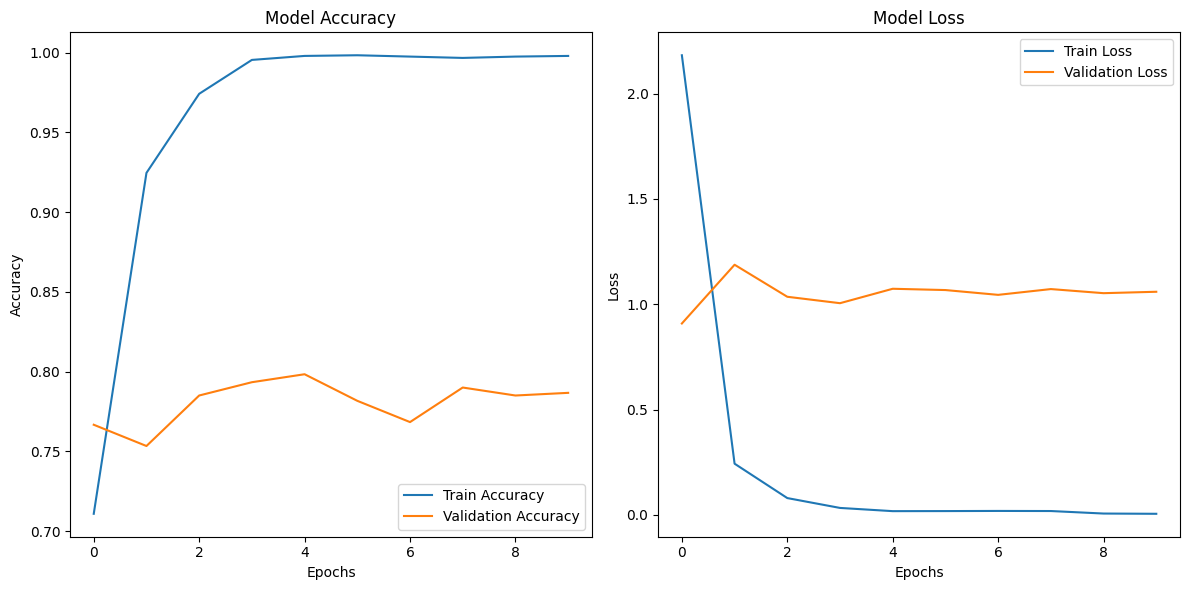

Accuracy and loss plot saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working\accuracy_loss_plot_20241223_083711.png
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step


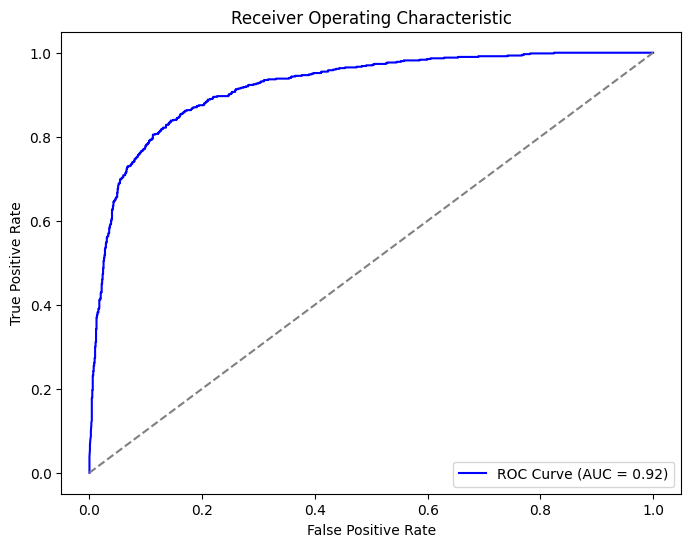

ROC Curve plot saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working\roc_curve_plot_20241223_083711.png


In [12]:
# Get current datetime and format it
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define file paths with timestamp
accuracy_loss_plot_path = os.path.join(WORKING_DIR, f'accuracy_loss_plot_{timestamp}.png')
roc_curve_plot_path = os.path.join(WORKING_DIR, f'roc_curve_plot_{timestamp}.png')

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save accuracy and loss plot with timestamp
plt.savefig(accuracy_loss_plot_path, dpi=300)  # Save with high resolution
plt.show()

print(f"Accuracy and loss plot saved at {accuracy_loss_plot_path}")

# ROC Curve
y_test_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test_encoded.ravel(), y_test_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Save ROC curve plot with timestamp
plt.savefig(roc_curve_plot_path, dpi=300)  # Save with high resolution
plt.show()

print(f"ROC Curve plot saved at {roc_curve_plot_path}")

In [13]:
# Load the saved model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
loaded_model = tf.keras.models.load_model(model_path)
print(f"Model loaded from {model_path}")

Model loaded from D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/SELECTED/object_detection_model_compare/working\mobilenet_v2_coco.keras


In [14]:
# Load COCO validation annotations
val_annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json')
coco_val = COCO(val_annotations_file)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [15]:
# Function to predict category for an image, now measuring inference time
def predict_category_with_time(image_path, model, target_size=(224, 224)):
    image = preprocess_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(image)
    inference_time = time.time() - start_time

    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    return predicted_class, confidence, inference_time

# Function to display image with prediction results and inference time
def display_image_with_prediction(image_path, predicted_label, confidence, inference_time):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display
    true_category = coco_val.cats[predicted_label]['name']  
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_category}\n"
              f"Predicted: {predicted_label} ({confidence*100:.2f}%)\n"
              f"Inference Time: {inference_time*1000:.2f} ms")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


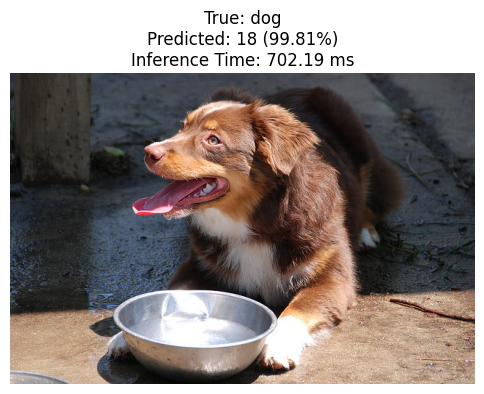

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


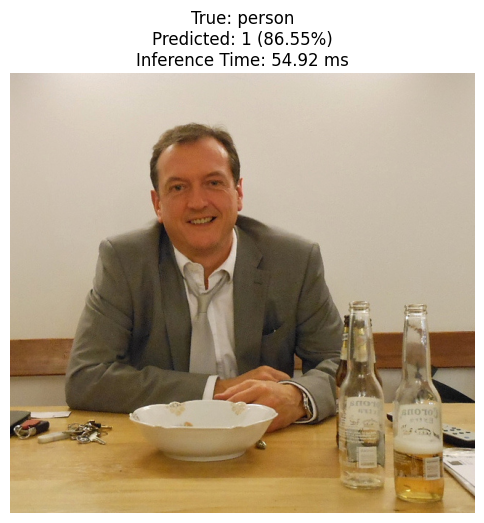

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


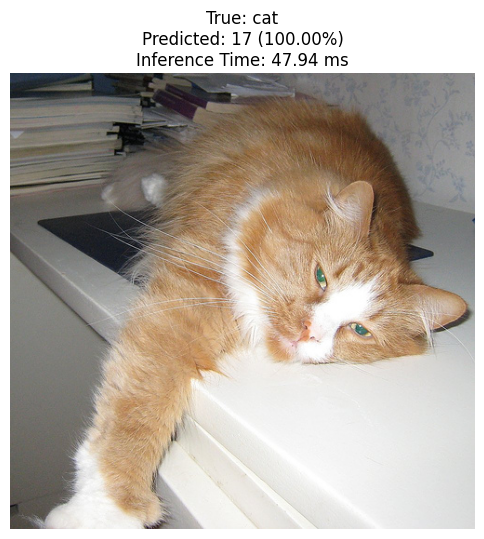

In [16]:
# Validate the model with a few images
image_filenames = ['000000205834.jpg', '000000050811.jpg', '000000058111.jpg']

# Create full paths for the images
validation_images = {filename: os.path.join(VAL_MODEL_IMG, filename) for filename in image_filenames}

# Perform predictions and display images with inference time
for filename, image_path in validation_images.items():
    predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    # Display image with prediction results and inference time
    display_image_with_prediction(image_path, predicted_label, confidence, inference_time)


In [17]:
#Generate Validation Dataset to infer medium acuracy and time 

# Collect up to 280 annotations per category
val_filtered_data = []
for category_id in category_ids:
    ann_ids = coco_val.getAnnIds(catIds=[category_id])
    anns = coco_val.loadAnns(ann_ids)
    selected_anns = random.sample(anns, min(280, len(anns)))
    for ann in selected_anns:
        image_info = coco_val.loadImgs(ann['image_id'])[0]
        val_filtered_data.append({
            "image_id": ann['image_id'],
            "image": image_info['file_name'],
            "category_id": ann['category_id']
        })

# Save filtered data to CSV
val_filtered_csv_path = os.path.join(WORKING_DIR, 'val_filtered_data.csv')
val_filtered_df = pd.DataFrame(val_filtered_data)
val_filtered_df.to_csv(val_filtered_csv_path, index=False)

print(f"Validation Filtered dataset saved to {os.path.abspath(val_filtered_csv_path)}")


# Load the filtered CSV
val_data = pd.read_csv(val_filtered_csv_path)

# Display record count per category_id to validate
val_category_counts = val_data['category_id'].value_counts()
print("Record count per category_id:")
print(val_category_counts)
print("")

Validation Filtered dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\object_detection_model_compare\working\val_filtered_data.csv
Record count per category_id:
category_id
1     280
18    218
17    202
Name: count, dtype: int64



In [18]:
# Add new columns to val_data
val_data['predicted_class'] = None
val_data['confidence'] = None
val_data['inference_time'] = None

# Process each record in val_data
for index, row in val_data.iterrows():
    image_path = os.path.join(VAL_PATH, row['image'])  # Construct full image path    
    predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Save results to val_data
    val_data.at[index, 'predicted_class'] = predicted_label
    val_data.at[index, 'confidence'] = round(confidence * 100, 2)
    val_data.at[index, 'inference_time'] = inference_time

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [19]:
# Save filtered data to CSV
val_data_inference_csv_path = os.path.join(WORKING_DIR, 'val_data_inference.csv')
val_data_inference = pd.DataFrame(val_data)
val_data_inference.to_csv(val_data_inference_csv_path, index=False)

print(f"Validation Filtered dataset saved to {os.path.abspath(val_data_inference_csv_path)}")    

Validation Filtered dataset saved to D:\Projetos\Mestrado\2024_Topicos_Esp_Sist_Informacao\ARTIGO_FINAL\SELECTED\object_detection_model_compare\working\val_data_inference.csv


In [24]:
# Calculate and display averages
average_confidence = val_data['confidence'].mean()
average_inference_time = val_data['inference_time'].mean()

print(f"Average Confidence: {average_confidence:.2f}%")
print(f"Average Inference Time: {average_inference_time*1000:.2f} ms")
print("")
print(f"Total Validation Records: {val_data.shape[0]}")
print("")

# Identify mismatches
mismatched_records = val_data[val_data['predicted_class'] != val_data['category_id']]
print(f"Records where predicted_class differs from category_id: {mismatched_records.shape[0]}")
print("")

# Identify equals
equals_records = val_data[val_data['predicted_class'] == val_data['category_id']]
equals_count = equals_records.shape[0]
print(f"Records where predicted_class equals category_id: {equals_count}")
print("")

# Calculate percentage of matches
total_records = val_data.shape[0]
percentage_equals = (equals_count / total_records) * 100
print(f"Percentage of records where predicted_class equals category_id: {percentage_equals:.2f}%")


Average Confidence: 93.30%
Average Inference Time: 50.69 ms

Total Validation Records: 700

Records where predicted_class differs from category_id: 140

Records where predicted_class equals category_id: 560

Percentage of records where predicted_class equals category_id: 80.00%
